## Potential paper layout - key questions/results

In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
import glob
import os
#from datetime import datetime
import datetime as dt
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from oceans.datasets import etopo_subset
# from oceans.sw_extras import gamma_GP_from_SP_pt
from matplotlib.patches import Polygon
# import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io
#import pixiedust # for pixie_debugger
import pycwt as wavelet
from itertools import islice # for slice OrderedDict
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
import cartopy.crs as ccrs

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_calc_functions as cf
import Benguela.src.met132_plotting_functions as fg
import Benguela.src.met132_sea_level_functions as sl
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

In [2]:
plt.close(fig='all') # plots stay open with widget until closed; might have to run this often

In [3]:
sadcp_nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
figure_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/paper/'

def read_in_scan_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    scan_sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_'+transect_name+'.nc')) 
    scan_sadcp_transects_xkm = scan_sadcp_transects_xkm.set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
    return scan_sadcp_transects_xkm
def read_in_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_'+transect_name+'.nc')) 
    sadcp_transects_xkm = sadcp_transects_xkm.set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
    return sadcp_transects_xkm
def read_in_ctdladcp(ctd_ladcp_transects_xkm,transect_name):
    ctd_ladcp_transects_xkm[transect_name] = xr.open_dataset((sadcp_nc_dir+'ctd_ladcp_transects_'+transect_name+'.nc')) 
    ctd_ladcp_transects_xkm[transect_name] = ctd_ladcp_transects_xkm[transect_name].set_index(xy=['x_m','x_km','lat','lon','time','station'])
    return ctd_ladcp_transects_xkm
# ds.map only works on datasets, so need to us e.g. ds[['ro']]
def standardize(x):
    return (x - x.mean()) / x.std()

# ====== load SADCP and Scanfish data
scan_sadcp_transects_1km = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km['WestwardFromUpwellTransect1'] = read_in_sadcp('WestwardFromUpwellTransect1')
scan_sadcp_transects_1km['ToCapetown1'] = read_in_sadcp('ToCapetown1')
scan_sadcp_transects_1km['AwayFromFilament1'] = read_in_sadcp('AwayFromFilament1')
scan_sadcp_transects_1km['FullScanTransect1'] = read_in_sadcp('FullScanTransect1')
scan_sadcp_transects_1km['ScanTransect2'] = read_in_sadcp('ScanTransect2')

scan_sadcp_transects_1km_filament = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km_filament['ScanTransect1'] = read_in_scan_sadcp('ScanTransect1')
scan_sadcp_transects_1km_filament['ScanTransect2'] = read_in_scan_sadcp('ScanTransect2')
scan_sadcp_transects_1km_filament['AcrossFilament1'] = read_in_sadcp('AcrossFilament1')

# ====== average spectra from transects that cross filament
spec_pyspec_filament_5 = xr.open_dataset(sadcp_nc_dir+'average_filament_spectra_without_CTD_transects.nc')
# average spectra from transects in upwelling region
spec_pyspec_upwell_4 = xr.open_dataset(sadcp_nc_dir+'average_upwelling_spectra_4_transects.nc')

# ====== KE 
for key in scan_sadcp_transects_1km:
    scan_sadcp_transects_1km[key] = cf.calc_KE(scan_sadcp_transects_1km[key])    
# KE 
for key in scan_sadcp_transects_1km_filament:
    scan_sadcp_transects_1km_filament[key] = cf.calc_KE(scan_sadcp_transects_1km_filament[key])    
    if 'sigma_0' in scan_sadcp_transects_1km_filament[key]:
        scan_sadcp_transects_1km_filament[key] = cf.calc_Ri_Balanced(scan_sadcp_transects_1km_filament[key])
        scan_sadcp_transects_1km_filament[key] = cf.SI_GI_Check(scan_sadcp_transects_1km_filament[key])

# ====== load SST map
# #filenames = "/Volumes/Backup/UniH/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016324.L3m_DAY_SST_sst_4km.nc"
# sadcp_nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
# filenames = sadcp_nc_dir+"A2016324.L3m_DAY_SST_sst_4km.nc"
# sst_map_19 = xr.open_dataset(filenames) # lat,lon,sst
def load_sst_map(filename):
    sst_map = xr.open_dataset(filename)
    return sst_map

filenames = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/Remote_Sensing/downloaded_sst_nc_files_on_20.11.2019/'
sst_map = OrderedDict() # Preallocate output dictionary
days = np.append(np.arange(1115,1131,1),np.arange(1201,1213,1))
file_nums = np.arange(320,348,1)
for ii in range(days.size):
    sst_map[('sst_map_'+str(days[ii]))] = load_sst_map((filenames+'A2016'+str(file_nums[ii])+'.L3m_DAY_SST.x_sst.nc'))

# ====== load SSH map
gos_map = xr.open_dataset(sadcp_nc_dir+'sla_gos.nc')
# ====== sadcp for full cruise ship track
sadcp = xr.open_dataset(sadcp_nc_dir+'sadcp_1km.nc')

# ====== load drifter tracks and velocities and spectra
nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
drifters = OrderedDict() # Preallocate output dictionary
for ii in np.arange(1,13): 
    drifters[('Drifter'+str(ii))] = xr.open_dataset(nc_dir+'drifter_Drifter'+str(ii)+'.nc')
    drifters[('Drifter'+str(ii))].coords['x_km'] = drifters[('Drifter'+str(ii))].coords['x_m']/1e3
    drifters[('Drifter'+str(ii))] = drifters[('Drifter'+str(ii))].swap_dims({'time': 'x_m'}).rename({'x_m': 'xy'})
    drifters[('Drifter'+str(ii))].coords['x_m'] = drifters[('Drifter'+str(ii))].coords['xy']
    drifters[('Drifter'+str(ii))] = drifters[('Drifter'+str(ii))].set_index(xy=['time','x_m','x_km']).expand_dims('z') 
    drifters[('Drifter'+str(ii))].attrs['TransectName'] = 'Drifter'+str(ii)

drifters2 = OrderedDict() # Preallocate output dictionary
for ii in np.arange(13,24): 
    drifters2[('Drifter'+str(ii))] = xr.open_dataset(nc_dir+'drifter_Drifter'+str(ii)+'.nc')
    drifters2[('Drifter'+str(ii))].coords['x_km'] = drifters2[('Drifter'+str(ii))].coords['x_m']/1e3
    drifters2[('Drifter'+str(ii))] = drifters2[('Drifter'+str(ii))].swap_dims({'time': 'x_m'}).rename({'x_m': 'xy'})
    drifters2[('Drifter'+str(ii))].coords['x_m'] = drifters2[('Drifter'+str(ii))].coords['xy']
    drifters2[('Drifter'+str(ii))] = drifters2[('Drifter'+str(ii))].set_index(xy=['time','x_m','x_km']).expand_dims('z')    
    drifters2[('Drifter'+str(ii))].attrs['TransectName'] = 'Drifter'+str(ii)

# spectra
spec_pyspec_drifters_1 = xr.open_dataset(sadcp_nc_dir+'average_drifter_deployment1_spectra_11_drifters.nc')
spec_pyspec_drifters_2 = xr.open_dataset(sadcp_nc_dir+'average_drifter_deployment2_spectra_11_drifters.nc')

spec_pyspec_drifters_1_15days = xr.open_dataset(sadcp_nc_dir+'average_drifter_deployment1_spectra_over_15_days.nc')
spec_pyspec_drifters_2_15days = xr.open_dataset(sadcp_nc_dir+'average_drifter_deployment2_spectra_over_15_days.nc')

# plot setup
depth_range= slice(-19,-50)
nbins_spec_av=10 # i.e. binned such that nbins_spec_av points are plotted for each order of magnitude (decade)
spec_variables = list(('full_ke',''))#,'ke_b'))

# where do the spectral slopes change?
k_slope_change = np.array((1e-5,4e-5, 2e-4,5e-4))
l_slope_change = 1e-3/k_slope_change[-1::-1]
front_locations = np.array([[5,15,55,65],[35,45,130,140],[28,38,65,75],[0,10,50,60]])

## ====== Wavelet power for KE (depth-averaged)
#transect_name_1 = 'ScanTransect1'
#transect_name_2 = 'ScanTransect2'
## averaging together wave power, or getting power of average data series is equivalent
#data_in_1 = scan_sadcp_transects_1km_filament[transect_name_1][spec_variables[0]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
#wave_out_small_1 = sw.run_wavelet(data_in_1, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_submeso_1 = sw.run_wavelet(data_in_1, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_meso_1 = sw.run_wavelet(data_in_1, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#
#data_in_2 = scan_sadcp_transects_1km_filament[transect_name_2][spec_variables[0]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
#wave_out_small_2 = sw.run_wavelet(data_in_2, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_submeso_2 = sw.run_wavelet(data_in_2, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_meso_2 = sw.run_wavelet(data_in_2, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#
#data_in_3 = scan_sadcp_transects_1km['FullScanTransect1'][spec_variables[0]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
#wave_out_small_3 = sw.run_wavelet(data_in_3, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_submeso_3 = sw.run_wavelet(data_in_3, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
#wave_out_meso_3 = sw.run_wavelet(data_in_3, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')

# ====== load MITgcm ECCO 4320 spectra; domain and transects
mitgcm_ecco_4320_domainSpectra = xr.open_dataset(sadcp_nc_dir+'ke_spectra_from_small_domain_MITgcm_ECCO.nc')

plt.rcParams.update({'font.size': 18,'legend.fontsize': 14})


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of emp

In [4]:
# combining drifter data into one dataset
ndays = 30 # focus on first 30 days
di = 0
# interp so timestamps match across drifters
new_time = np.arange(drifters['Drifter1'].time[1].values, drifters['Drifter1'].time[1].values+np.timedelta64(ndays, 'D'),
                     (drifters['Drifter1'].time[2]-drifters['Drifter1'].time[1]).values).astype('datetime64[30m]')

for key in drifters:
    
    if di == 0: 
        drifter_ds = (drifters[key].reset_index('xy').swap_dims({'xy':'time'})
                              .squeeze().interp(time=new_time))
    else:
        # match timestamps
        d_temp = (drifters[key].reset_index('xy').swap_dims({'xy':'time'})
                  .squeeze().interp(time=new_time))
        drifter_ds = xr.concat((drifter_ds,d_temp),dim='drifter')
    di = di+1
drifter_ds['drifter'] = list(drifters.keys())

sadcp['vel'] = (sadcp.u**2 + sadcp.v**2)**0.5
adcp_vel = sadcp['vel'].sel(z=-15,method='nearest')

gos_map['vel'] = (gos_map.ugos**2 + gos_map.vgos**2)**0.5
ssh_vel = gos_map.sel(lon=slice(9,16),lat=slice(-28,-24)).isel(time=slice(0,31)).vel.stack(iter=('lon','lat','time')).reset_index('iter').drop(['lat','lon','time'])


#####    1. Map of study area, cruise track, and drifter tracks


8.5 15.5
8.5 15.5


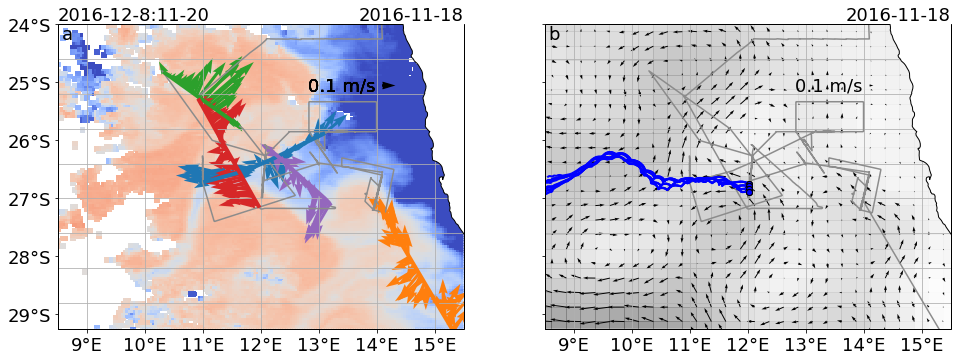

In [5]:
import cartopy.crs as ccrs
plt.rcParams.update({'font.size': 18})

si, nrows, ncols =  0, 1,2
projection = ccrs.PlateCarree()
x_y_lim = [8.5,15.5,-24.,-29.25]
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*8.,nrows*6),subplot_kw=dict(projection=projection))
axs = axs.ravel()

# ==== SST map, ship track and transects
axs[0] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = scan_sadcp_transects_1km, topo=None,
                 sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],axs=[axs[0],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[0].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# ==== SSH map, ship track and drifters
axs[1] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                        sst_map=None, sst_map1=gos_map.sel(time='2016-11-18',lon=slice(6,19),lat=slice(-30,-21)),ssh_name='adt', 
                        x_lim=[0,150],axs=[axs[1],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],greyscale_cmap=True,ssh_vel=True,y_axis_label_off=True,projection = projection)

ndays = 15
for key in drifters:
    axs[1].plot(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=slice(drifters[key].time[0],drifters[key].time[0].values  + np.timedelta64(ndays, 'D') )).values,
              drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=slice(drifters[key].time[0],drifters[key].time[0].values  + np.timedelta64(ndays, 'D') )).values,
              lw = 2, color='blue',transform= projection)
    axs[1].plot(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=drifters[key].time[0]).values,
              drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=drifters[key].time[0]).values,
              marker='o', markerfacecolor='blue', markeredgecolor='k',transform= projection)
axs[1].set_yticklabels([])
axs[1].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors
    
fg.label_axes(fig,loc=(0.01,0.95))

figname = figure_dir+'Figure_1_maps_of_transects_drifter_SST_SSH.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')



#####    2a. Filament formation, evolution, lifetime, ...


8.5 15.5
8.5 15.5
8.5 15.5
8.5 15.5
8.5 15.5
8.5 15.5
8.5 15.5
8.5 15.5


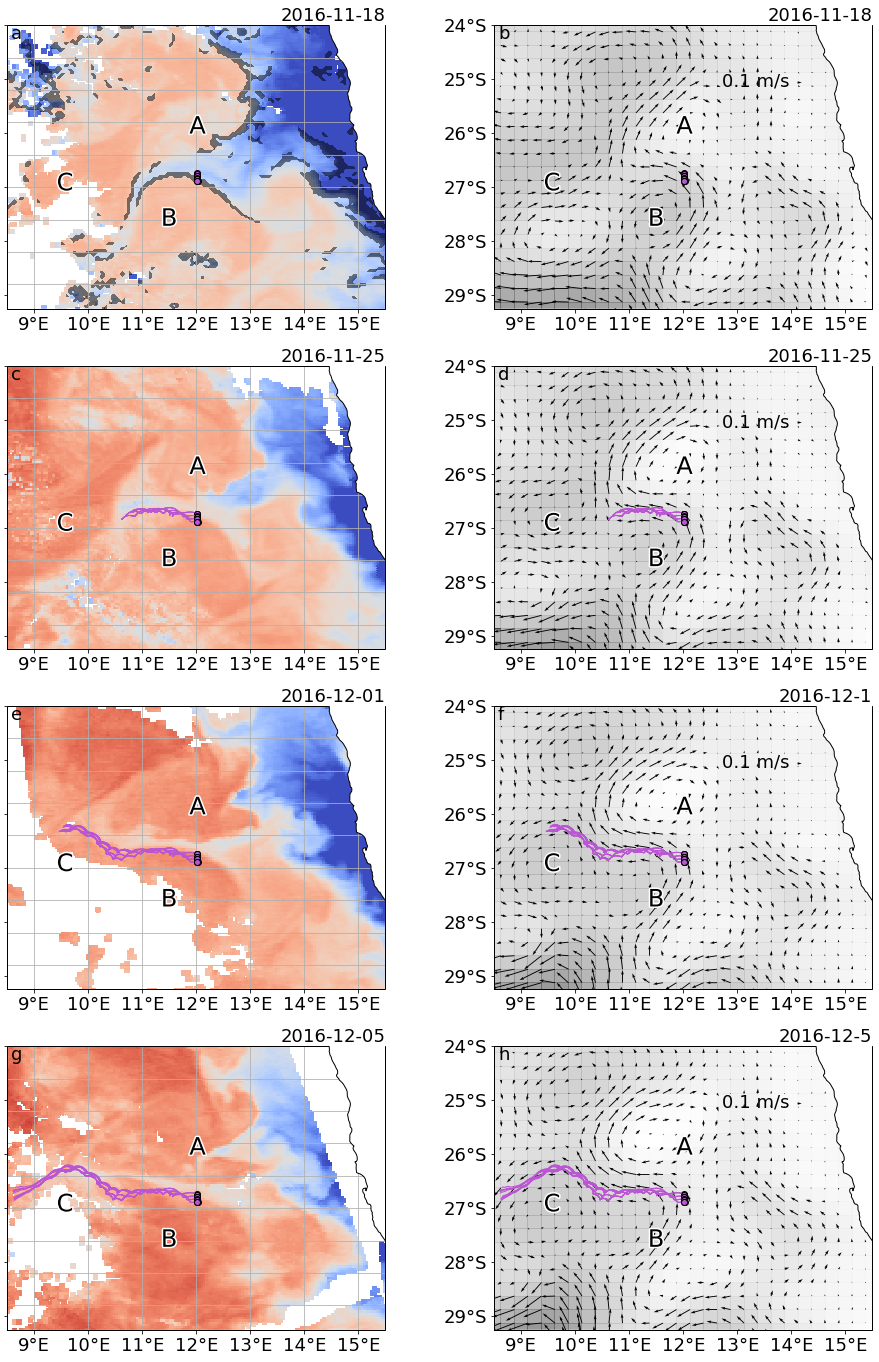

In [6]:
plt.rcParams.update({'font.size': 18})

def plot_drifters(ndays,ax):
    for key in drifters:
        ax.plot(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=slice(drifters[key].time[0],drifters[key].time[0].values  + np.timedelta64(ndays, 'D') )).values,
                  drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=slice(drifters[key].time[0],drifters[key].time[0].values  + np.timedelta64(ndays, 'D') )).values,
                  lw = 1, alpha=1, color=color6,transform= projection)
        ax.plot(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=drifters[key].time[0]).values,
                  drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=drifters[key].time[0]).values,
                  marker='o', markerfacecolor=color6, markeredgecolor='k',transform= projection)
import matplotlib.patheffects as PathEffects
def text_w_outline(x,y,letter,ax):
    txt = plt.text(x,y,letter,horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes,fontsize=24)     
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    
nrows, ncols =  4,2
projection = ccrs.PlateCarree()
x_y_lim = [8.5,15.5,-24.,-29.25]
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*8.,nrows*6),subplot_kw=dict(projection=projection))
axs = axs.ravel()

sst_4 = OrderedDict()
sst_4['sst_map_1118'] = sst_map['sst_map_1118']
sst_4['sst_map_1125'] = sst_map['sst_map_1125']
sst_4['sst_map_1201'] = sst_map['sst_map_1201']
sst_4['sst_map_1205'] = sst_map['sst_map_1205']

si = 0
drift_offset = np.array((21,25,31,35))
for key,do in zip(sst_4,drift_offset): 
    axs[si] = fg.plot_map_view(sadcp=None, scan_sadcp = None, topo=None,
                     sst_map=sst_4[key], sst_map1=None, axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
    if si == 0: # add horizontal gradient
        hgrad = np.gradient(sst_4[key].sst.values,2,2)
        sst_4[key]['sst_grad'] = xr.full_like(sst_4[key].sst,np.sqrt(hgrad[0]**2 + hgrad[1]**2))/np.array(sst_4[key].spatialResolution[0:4],dtype='float32') # deg/km
        lon2, lat2 = np.meshgrid(sst_4[key].lon.values,sst_4[key].lat.values)
        axs[si].contourf(lon2, lat2, sst_4[key]['sst_grad'].where(sst_map[key]['sst_grad']>=0.03),
                         alpha=0.5,colors='k',levels=[0.01,0.5],transform= projection)
#         sst_4[key]['sst_grad'].plot.contour(vmax=0.5,ax=axs[si],colors='k',levels=[0.2],linewidths=0.5)
    plot_drifters(do-21,axs[si]) # drifters[key].time[0].values = 11.21
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_yticklabels([])
    axs[si].gridlines()
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si+2

# ==== SSH map and drifters
si = 1
ssh_time = list(('2016-11-18','2016-11-25','2016-12-01','2016-12-05'))
for sshtime,do in zip(ssh_time,drift_offset):
    axs[si] = fg.plot_map_view(sadcp=None, scan_sadcp = None, topo=None,
                            sst_map=None, sst_map1=gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)),ssh_name='adt', 
                            axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],greyscale_cmap=True,ssh_vel=True,y_axis_label_off=True,projection = projection)
    plot_drifters(do-21,axs[si]) # drifters[key].time[0].values = 11.21
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si +2

fg.label_axes(fig,loc=(0.01,0.95))

figname = figure_dir+'Figure_2_maps_timeseries_filament_SST_SSH.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


#####    3. Velocities in the filament and region

Drifter  30
SADCP  23.0
SSH  30.0


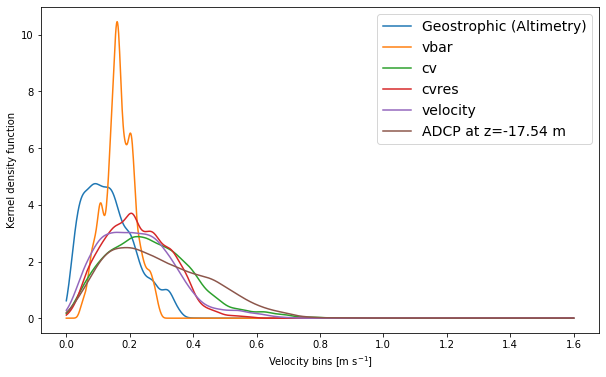

In [57]:
%matplotlib inline
si, nrows, ncols =  0, 1, 1
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))

# convert to Pandas Series and get PDF
# Generate Kernel Density Estimate plot using Gaussian kernels. a non-parametric way to estimate the probability density function (PDF) of a random variable
vel_range = np.linspace( np.min(np.array((drifter_ds.ellipse_velocity.min(),ssh_vel.min(),adcp_vel.min()))), np.max(np.array((drifter_ds.ellipse_velocity.max(),ssh_vel.max(),adcp_vel.max()))), 1000)
ssh_vel.to_pandas().plot.kde(ind = vel_range,label='Geostrophic (Altimetry)',ax=axs)   # include points where to evaluate
drifter_ds.ellipse_velocity.sel(velocity_type=['vbar','cv','cvres','velocity']).stack(new_time=['drifter','time']).dropna('new_time',how='all').drop(['x_m','x_km','z']).T.to_pandas().plot.kde(ind = vel_range,ax=axs)
adcp_vel.to_pandas().plot.kde(ind = vel_range,label=('ADCP at z='+str(adcp_vel.z.values)+' m'),ax=axs)   # include points where to evaluate
plt.legend()

plt.xlabel('Velocity bins [m s$^{-1}$]')
plt.ylabel('Kernel density function')

figname = figure_dir+'Figure_3_PDF_velocities.pdf'
fig.savefig(figname,orientation='landscape', bbox_inches='tight')

# how many drifter days?
days = (drifters['Drifter1'].time[-1]-drifters['Drifter1'].time[0]).astype('timedelta64[D]')
print('Drifter ', ndays) #days.values / np.timedelta64(1, 'D'))
days = (sadcp.time[-1]-sadcp.time[0]).astype('timedelta64[D]')
print('SADCP ', days.values / np.timedelta64(1, 'D'))
days = (gos_map.isel(time=slice(0,31)).time[-1]-gos_map.isel(time=slice(0,31)).time[0]).astype('timedelta64[D]')
print('SSH ', days.values / np.timedelta64(1, 'D'))


In [58]:
import hvplot.xarray
drifter_ds.ellipse_velocity.dropna('time',how='all').hvplot.kde('ellipse_velocity',by='velocity_type',alpha=0.5)*ssh_vel.hvplot.kde()*adcp_vel.hvplot.kde()
# labels not working for last two

:Overlay
   .NdOverlay.I   :NdOverlay   [velocity_type]
      :Distribution   [ellipse_velocity]   (Density)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Distribution   [value]   (Density)
   .NdOverlay.III :NdOverlay   [Variable]
      :Distribution   [value]   (Density)

#####    4. Characteristics of filament:
- TO DO: 
    - what did we learn that has not been reported before
    - microstructure to show depth dependence and horizontal (compare inside, outside and edge of filament - maybe more qualitative than quantitative, but something)
- horizontal temperature gradients of up to 2 degrees, salinity .3 g/kg, and density .3 kg/m3
- along-filament velocity component (0.5 m/s) is at a maximum towards the southern side of the eddy and are surface concentrated
- the filament shows a decrease in surface mixed layer depth compared to the surrounding
- Ekman transport towards south visible in salinity (plot above)
- Across-front velocities converge at filament fronts, suggesting downwelling along isopycnals on both sides of filament. 
- Upwelling regions? or is it only downwelling since upwelling is along the coast?
- Outside of filament fronts there are compensating lateral density gradients in T,S resulting in not gradients in rho (leave meaning wrt mixing for discussion)

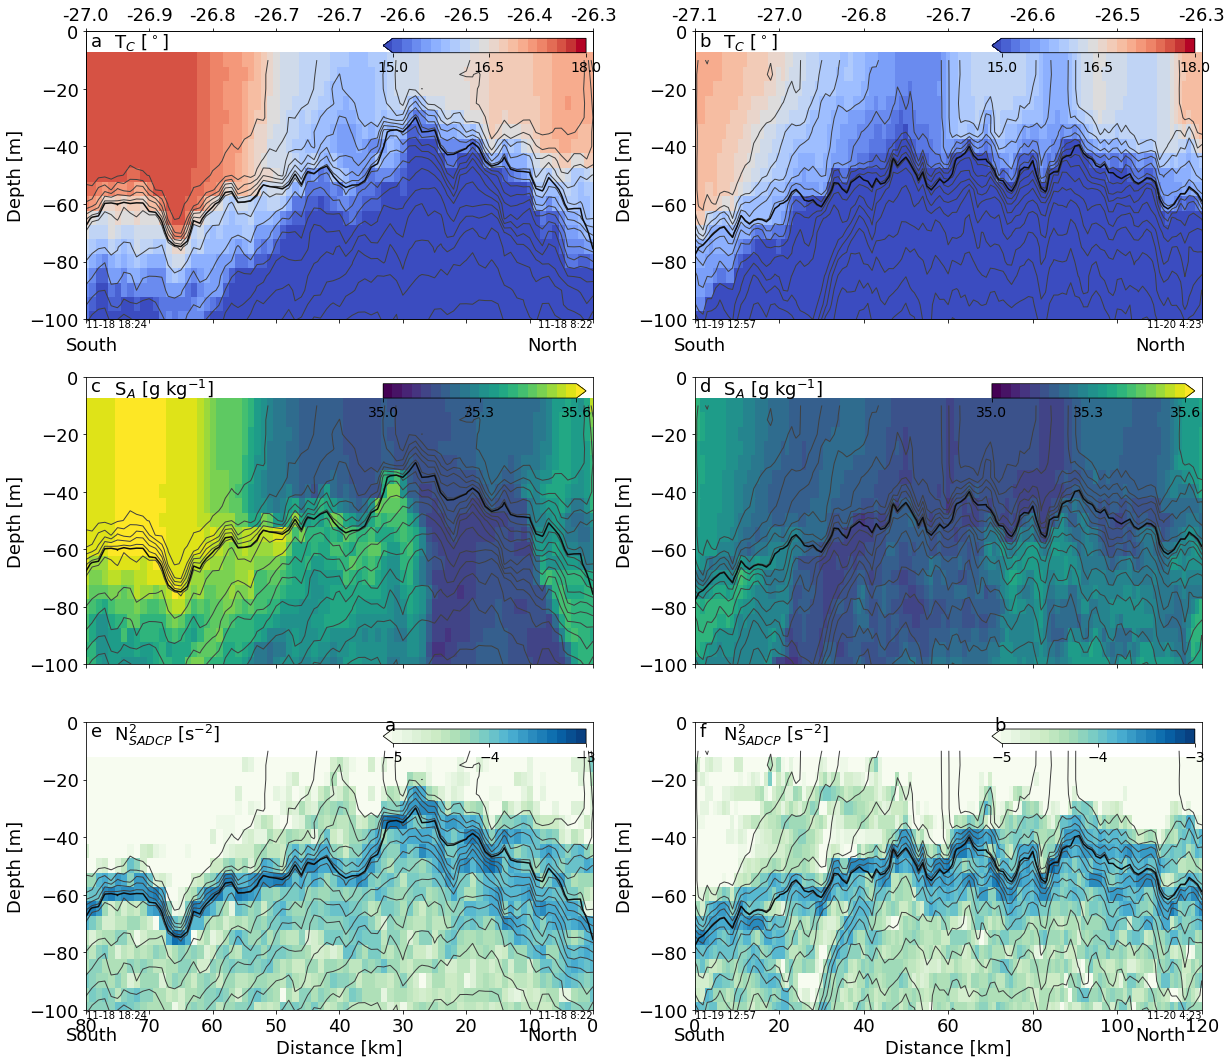

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Mixed layer depth and stratification
##### - MLD defined from a critical density criterion of 0.25 kg m-3, as this aligns well with maximum N2 
x_lim, y_lim = [0,80], [-100,0]

si, nrows, ncols =  0, 3,2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
var_names = list(('CT','SA'))
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 0, 1)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si],axs[si+2])),last_row_flag=None, 
                               mld_flag = True,pcolormesh_flag=True,first_row_flag=True)
x_lim = [0,120]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 1, 2)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+1],axs[si+3])),last_row_flag=None, 
                               mld_flag = True,pcolormesh_flag=True,first_row_flag=True)
var_names = list(('db_dz_log10',''))
x_lim, y_lim = [0,80], [-100,0]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 0, 1)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+4],'')),last_row_flag=True, 
                               mld_flag = True,pcolormesh_flag=True)
x_lim = [0,120]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 1, 2)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+5],'')),last_row_flag=True, 
                               mld_flag = True,pcolormesh_flag=True)

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','','','','')),loc=(0.01,0.95))

# fname='s%03d.png'%i
figname = figure_dir+'Figure_4_sections_filament_CT_SA_sigma_N2_2transects.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')


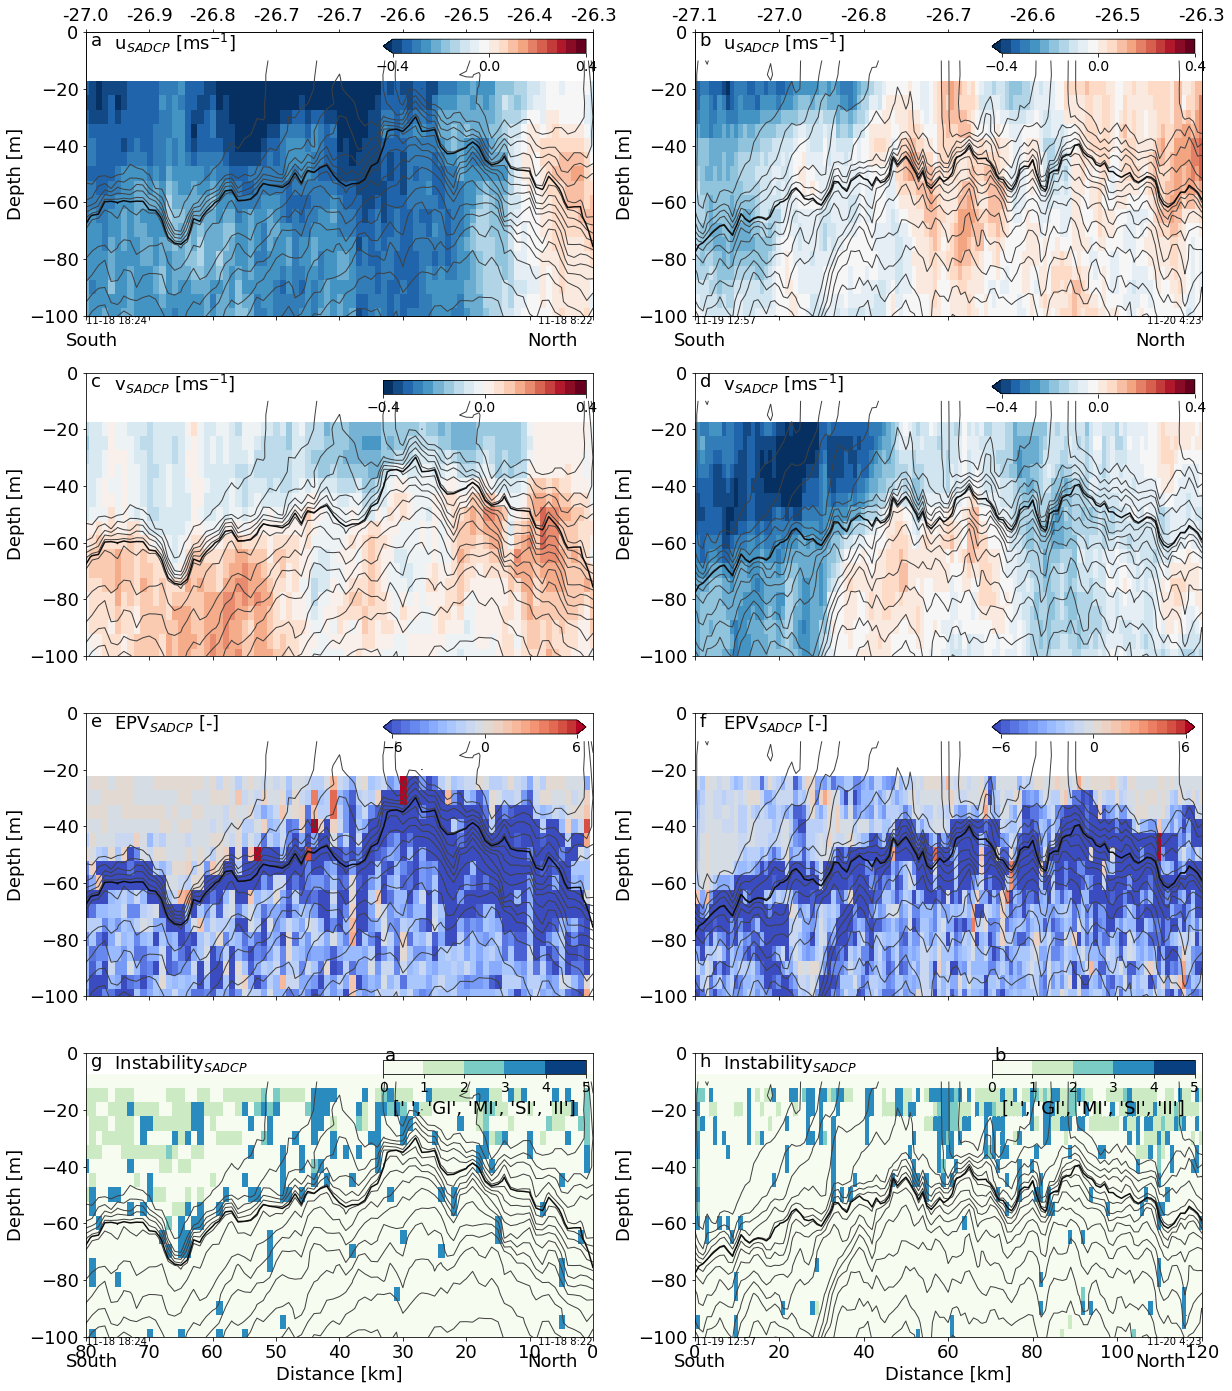

In [5]:
import warnings
warnings.filterwarnings('ignore')

#### Mixed layer depth and stratification
##### - MLD defined from a critical density criterion of 0.25 kg m-3, as this aligns well with maximum N2 
x_lim, y_lim = [0,80], [-100,0]

si, nrows, ncols =  0, 4,2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
var_names = list(('u','v','EPV_plot'))
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 0, 1)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si],axs[si+2],axs[si+4])),last_row_flag=None, 
                               mld_flag = True,pcolormesh_flag=True,first_row_flag=True)
x_lim = [0,120]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 1, 2)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+1],axs[si+3],axs[si+5])),last_row_flag=None, 
                               mld_flag = True,pcolormesh_flag=True,first_row_flag=True)
var_names = list(('Instability_StableGravMixSymInertStab',''))
x_lim, y_lim = [0,80], [-100,0]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 0, 1)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+6],'')),last_row_flag=True, 
                               mld_flag = True,pcolormesh_flag=True)
x_lim = [0,120]
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 1, 2)) , None, var_names, 
                               x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si+7],'')),last_row_flag=True, 
                               mld_flag = True,pcolormesh_flag=True)

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','','','','','','','','')),loc=(0.01,0.95))

# fname='s%03d.png'%i
figname = figure_dir+'Figure_6_sections_filament_u_v_EPV_instab_2transects.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

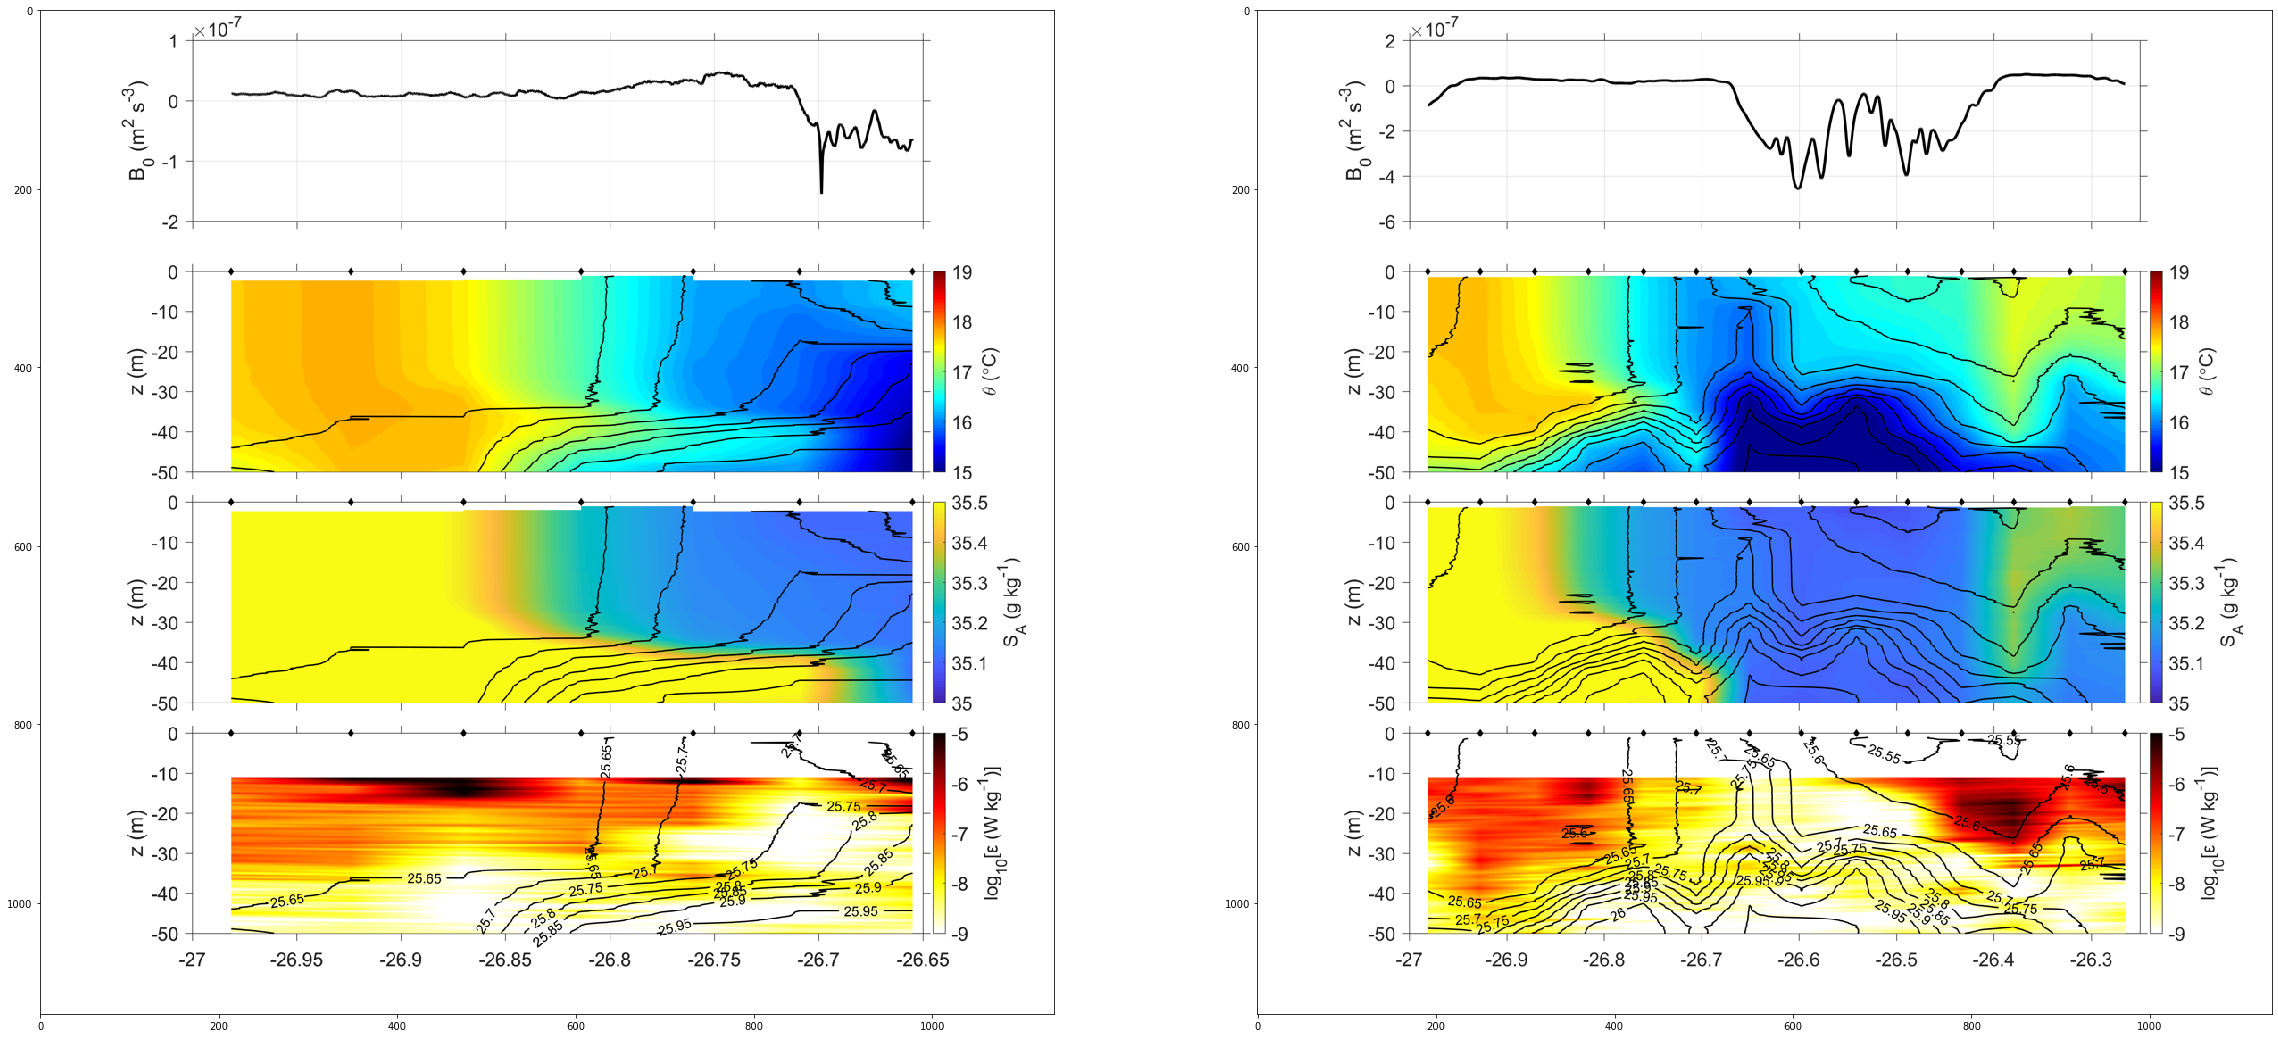

In [37]:
    

from IPython.display import Image
import matplotlib.image as mpimg
%matplotlib inline
img_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/images/'

si, nrows, ncols =  0, 1,2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*20.,nrows*22))
axs = axs.ravel()

filename1 = 'Transect1_11_20_1900_11_21_0800.png'
filename2 = 'Transect2_11_21_1500_11_22_2300.png'
images = [mpimg.imread(img_dir+filename1),mpimg.imread(img_dir+filename2)]

cols = 2
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

#### 5. Drifter velocities and temperature

In [150]:
ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))
dlon = 0.01
binned_lons = np.arange(x_y_lim[0],x_y_lim[1],dlon)
binned_lons_c = binned_lons[0:-1]+(dlon/2)

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


##### Time-series of drifter velocities, temperatures, ellipse radii

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of emp

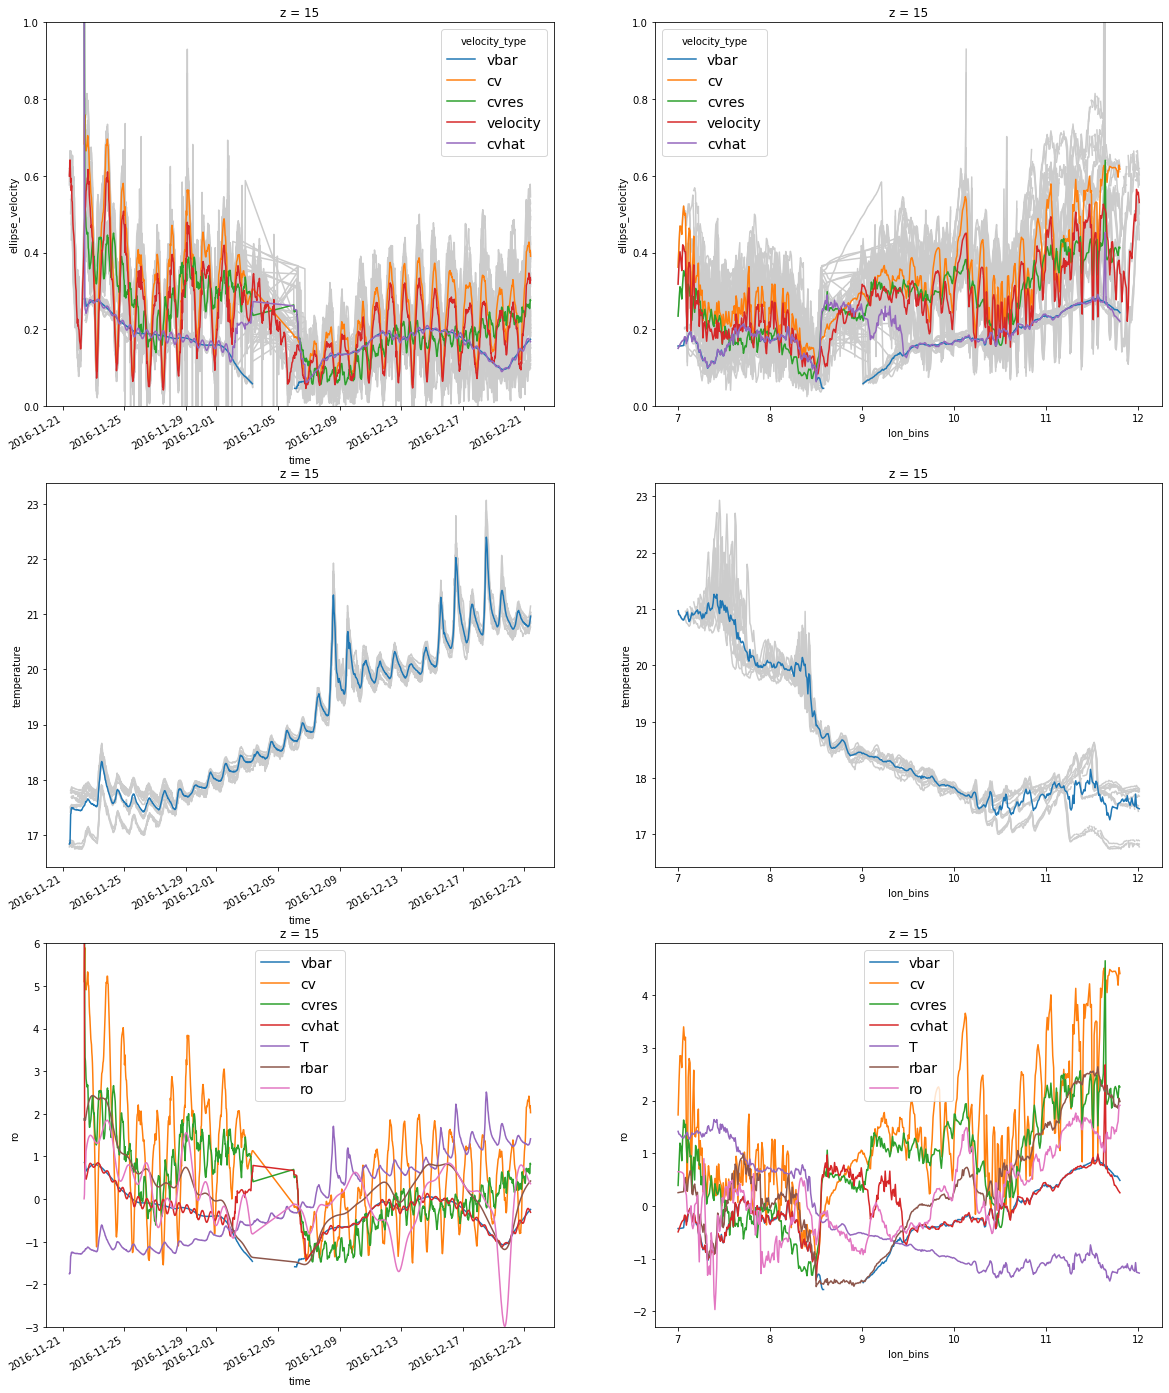

In [154]:
%matplotlib inline
ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))

key = 'Drifter5'

nrows, ncols =  3,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== velocity time-series of all drifters
si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)

for drift in drifter_ds.ellipse_velocity.drifter:
    (drifter_ds.ellipse_velocity.sel(time=sel_time,drifter=drift).sel(velocity_type=['vbar','cv','cvres','velocity','cvhat']).squeeze().
     plot(x='time',hue='velocity_type',color='0.8',ax=axs[si],linestyle='-'))

(drifter_ds.ellipse_velocity.sel(time=sel_time).sel(velocity_type=['vbar','cv','cvres','velocity','cvhat']).mean('drifter').squeeze().
     plot(x='time',hue='velocity_type',ax=axs[si],linestyle='-'))
axs[si].set_ylim(0,1)

# ==== velocity groupby longitude of all drifters
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1)

for drift in drifter_ds.ellipse_velocity.drifter:
    (drifter_ds.set_coords(['lat','lon']).ellipse_velocity.sel(time=sel_time,drifter=drift).sel(velocity_type=['vbar','cv','cvres','velocity','cvhat']).squeeze().
     groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
     plot.line(x='lon_bins',hue='velocity_type',color='0.8',ax=axs[si]))

(drifter_ds.set_coords(['lat','lon']).ellipse_velocity.sel(time=sel_time).sel(velocity_type=['vbar','cv','cvres','velocity','cvhat']).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',hue='velocity_type',ax=axs[si]))
axs[si].set_ylim(0,1)

# ==== temperature time-series of all drifters
si = 2
axs[si] = plt.subplot(nrows, ncols, si+1)

(drifter_ds.temperature.sel(time=sel_time).squeeze().plot(x='time',hue='drifter',color='0.8',ax=axs[si],add_legend=False))
(drifter_ds.temperature.sel(time=sel_time).mean('drifter').squeeze().plot(x='time',ax=axs[si],add_legend=False))

# ==== temperature groupby longitude of all drifters
si = 3
axs[si] = plt.subplot(nrows, ncols, si+1)

for drift in drifter_ds.ellipse_velocity.drifter:
    (drifter_ds.set_coords(['lat','lon']).temperature.sel(time=sel_time,drifter=drift).squeeze().
     groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
     plot.line(x='lon_bins',hue='velocity_type',color='0.8',ax=axs[si]))

(drifter_ds.set_coords(['lat','lon']).temperature.sel(time=sel_time).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',ax=axs[si],add_legend=False))

# ==== compare time-series of drifter means
si = 4
axs[si] = plt.subplot(nrows, ncols, si+1)

p1 = (drifter_ds[['ellipse_velocity']].map(standardize).ellipse_velocity.
      sel(time=sel_time,velocity_type=['vbar','cv','cvres','cvhat']).mean('drifter').squeeze().
      plot(x='time',hue='velocity_type',ax=axs[si],linestyle='-',add_legend=False))

p2 = (drifter_ds[['temperature']].map(standardize).temperature.sel(time=sel_time).mean('drifter').squeeze().plot(x='time',ax=axs[si],label='T'))
p3 = (drifter_ds[['rbar']].map(standardize).rbar.sel(time=sel_time).mean('drifter').squeeze().plot(x='time',ax=axs[si],label='r_bar'))
p4 = ((drifter_ds[['ro']].map(standardize).ro.sel(time=sel_time).mean('drifter').squeeze()).plot(x='time',ax=axs[si],label='Ro'))
axs[si].legend([p1,p2,p3,p4],labels=['vbar','cv','cvres','cvhat','T','rbar','ro'])
axs[si].set_ylim(-3,6)

# ==== compare groupby longitude of drifter means  
si = 5
axs[si] = plt.subplot(nrows, ncols, si+1)

p1b = (drifter_ds.set_coords(['lat','lon'])[['ellipse_velocity']].map(standardize).ellipse_velocity.sel(time=sel_time).
 sel(velocity_type=['vbar','cv','cvres','cvhat']).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',hue='velocity_type',ax=axs[si],add_legend=False))

p2b = (drifter_ds.set_coords(['lat','lon'])[['temperature']].map(standardize).temperature.sel(time=sel_time).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',ax=axs[si],add_legend=False))
p3b = (drifter_ds.set_coords(['lat','lon'])[['rbar']].map(standardize).rbar.sel(time=sel_time).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',ax=axs[si],add_legend=False))
p4b = (drifter_ds.set_coords(['lat','lon'])[['ro']].map(standardize).ro.sel(time=sel_time).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().
 plot.line(x='lon_bins',ax=axs[si],add_legend=False))
axs[si].legend([p1b,p2b,p3b,p4b],labels=['vbar','cv','cvres','cvhat','T','rbar','ro'])


## ==== KE time-series of all drifters
#si = 5
#axs[si] = plt.subplot(nrows, ncols, si+1)
#
#for drift in drifter_ds.ellipse_velocity.drifter:
#    (drifter_ds.kinetic_energy.sel(time=sel_time,drifter=drift).squeeze().
#     plot(x='time',hue='ke_type',color='0.8',ax=axs[si],linestyle='-'))
#
#(drifter_ds.kinetic_energy.sel(time=sel_time).mean('drifter').squeeze().
#     plot(x='time',hue='ke_type',ax=axs[si],linestyle='-'))


Period range:  0.04304348532288557 - 31.166812526301204
2 15 1.9977427691689083 14.238291777813695


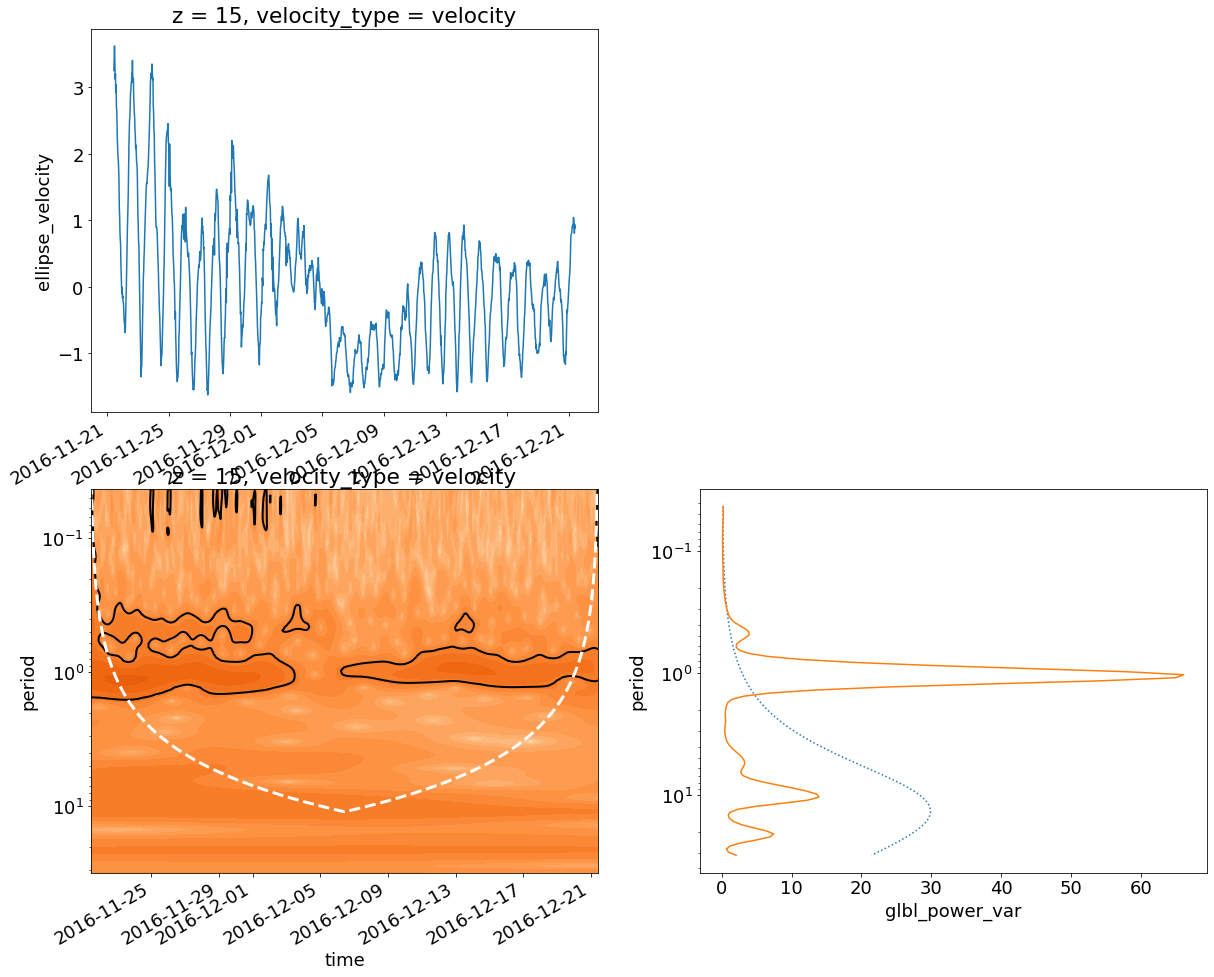

In [5]:
ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))
dat_ar = (drifter_ds[['ellipse_velocity']].map(standardize).
          ellipse_velocity.sel(time=sel_time,velocity_type=['velocity']).mean('drifter').dropna('time',how='all').squeeze())
dat_wav = sw.run_wavelet(dat_ar,avg1=[2,15])
            
nrows, ncols =  3,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== velocity time-series mean of drifters
si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)
dat_wav.ellipse_velocity.plot()

# ==== wavelet power of velocity time-series mean of drifters
si = 2
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_WavePower(dat_wav,axs[si],time_name='time',period_name='period')

# ==== global wavelet power velocity time-series mean of drifters
si = 3
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_GWS(dat_wav,axs[si],time_name='time',period_name='period',fft_theor=False)

Period range:  0.04304348532288557 - 31.166812526301204
2 15 1.9977427691689083 14.238291777813695


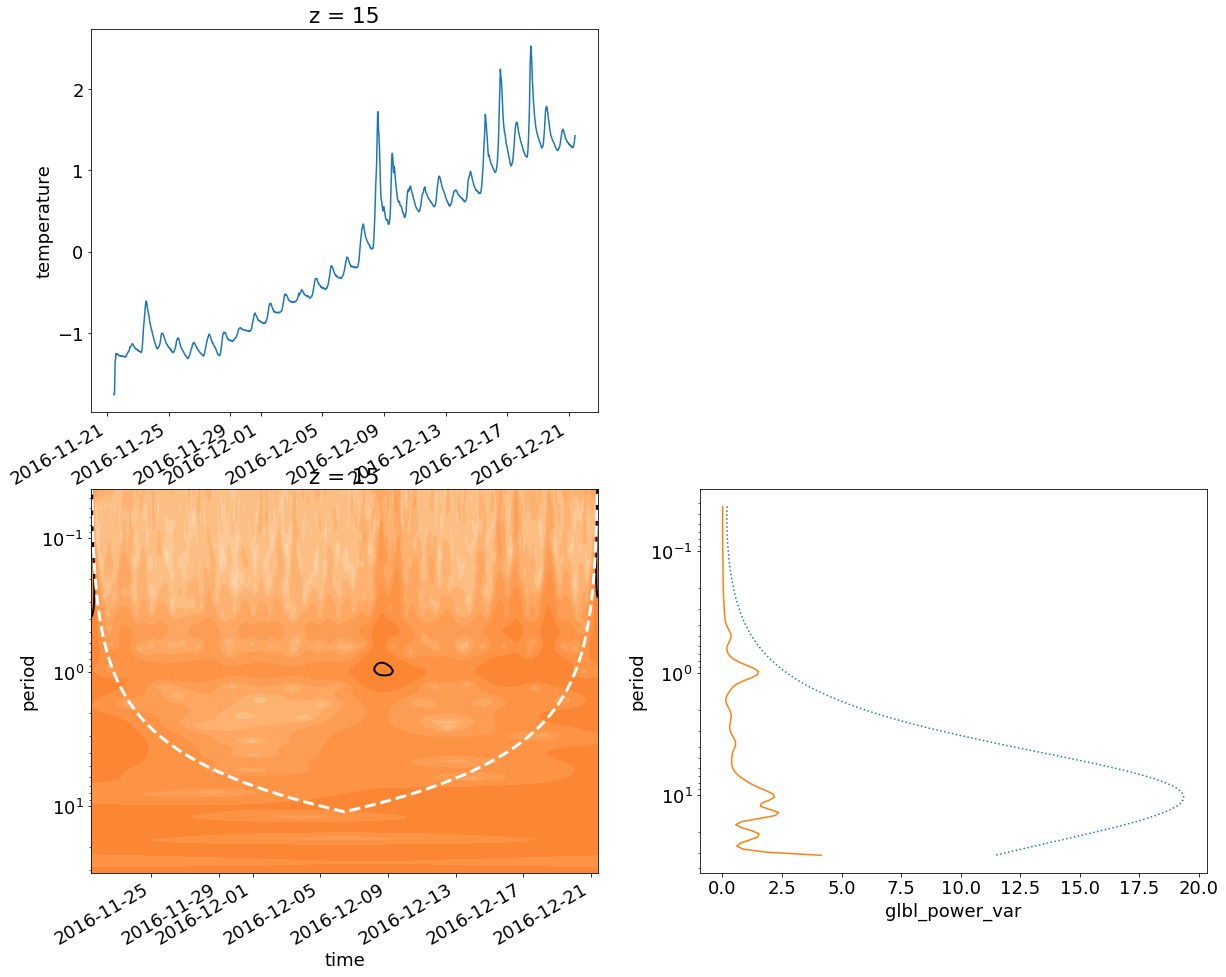

In [11]:
ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))
dat_ar = (drifter_ds[['temperature']].map(standardize).
          temperature.sel(time=sel_time).mean('drifter').dropna('time',how='all').squeeze())
dat_wav = sw.run_wavelet(dat_ar,avg1=[2,15],ssa_filter=False)
            
nrows, ncols =  3,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== velocity time-series mean of drifters
si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)
dat_wav.temperature.plot()

# ==== wavelet power of velocity time-series mean of drifters
si = 2
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_WavePower(dat_wav,axs[si],time_name='time',period_name='period')

# ==== global wavelet power velocity time-series mean of drifters
si = 3
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_GWS(dat_wav,axs[si],time_name='time',period_name='period',fft_theor=False)

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/pycwt/wavelet.py:567: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/pycwt/wavelet.py:568: RuntimeWarning: invalid value encountered in less
  aa = np.abs(aa) + 0.5 * (aa < 0)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/numpy/ma/core.py:2795: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


NOTE: WCT significance loaded from cache.



/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Denmark_Strait/src/spectra_and_wavelet_functions.py:657: RuntimeWarning: invalid value encountered in greater
  crit_mat = np.logical_and(wct.sig95.values>1, xwt.sig95>1)


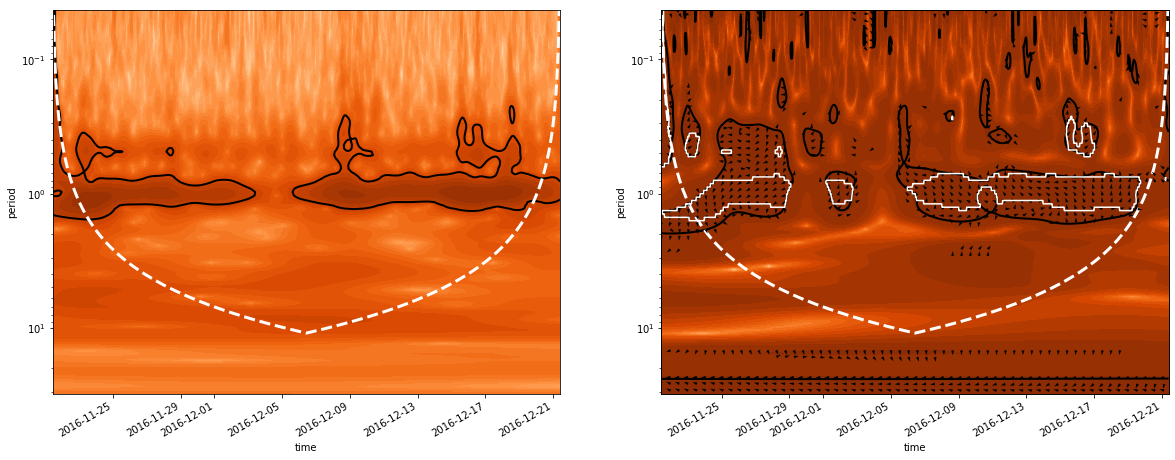

In [7]:
%matplotlib inline
ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))
t_dat_ar = (drifter_ds[['temperature']].map(standardize).
          temperature.sel(time=sel_time).mean('drifter').dropna('time',how='all').squeeze())
v_dat_ar = (drifter_ds[['ellipse_velocity']].map(standardize).
          ellipse_velocity.sel(time=sel_time,velocity_type=['velocity']).mean('drifter').dropna('time',how='all').squeeze())
t_dat_ar = t_dat_ar.interp_like(v_dat_ar,'nearest')
dt = np.diff(t_dat_ar.time).mean() # if actually time, must be in integer/float form; but this allows dx to be used to
if type(dt)==np.timedelta64:
    dt = dt.astype('float64')/(1e9*60*60*24) # ns to days

def ssa_filter_local(dat,window=150):
    if dat.size < 300:
        window = 25
    pc_s =  np.arange(1,window)
    pc_out, _, v_out = ssa.ssa(dat.values, window)
    ssa_out = ssa.inv_ssa(pc_out, v_out, pc_s)
    return ssa_out

t_dat_ar.values = ssa_filter_local(t_dat_ar)

xwt_ds, wct_ds = sw.run_cross_coherence_wavelet(v_dat_ar.values,t_dat_ar.values,t_dat_ar.time.values,dt,run_wct=True)

nrows, ncols =  3,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== 
si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_WavePower(xwt_ds,axs[si],power_name='XWT')
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1)
sw.waveplt_WavePower(wct_ds,axs[si],power_name='WCT')

!!! is angle check working correctly? 

wto = sw.wto_calc(wct_ds,xwt_ds,strict=2)
wto.plot.contour(levels=[0.5, 1.0],colors='w',yincrease=False)


 

In [94]:
wct_ds


<xarray.Dataset>
Dimensions:    (period: 115, scales: 115, time: 1440)
Coordinates:
  * scales     (scales) float64 0.04167 0.04414 0.04677 ... 26.88 28.48 30.17
  * period     (period) float64 0.04304 0.0456 0.04831 ... 27.77 29.42 31.17
  * time       (time) datetime64[ns] 2016-11-21T10:30:00 ... 2016-12-21T10:00:00
Data variables:
    data1      (time) float64 4.22 4.479 4.661 4.416 ... 1.476 1.283 1.441 1.376
    data2      (time) float64 -0.6777 -0.6671 -0.6718 ... -0.09978 -0.06644
    WCT        (period, time) float64 0.9866 0.9831 0.9768 ... 0.76 0.76 0.76
    aWCT       (period, time) float64 2.997 2.961 2.936 ... 2.787 2.787 2.787
    sig95      (period, time) float64 1.215 1.211 1.203 1.189 ... nan nan nan
    coi        (time) float64 0.007609 0.02283 0.03805 ... 0.02283 0.007609
    power_log  (period, time) float64 -0.005861 -0.007423 ... -0.1192 -0.1192

In [ ]:
!!! apply wavelets and cross-wavelets to mean drifter values to see correlation

In [6]:
# ds.map only works on datasets, so need to us e.g. ds[['ro']]
def standardize(x):
    return (x - x.mean()) / x.std()


##### Mapping drifter velocity and temperature

7 10
7 10


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7 10
7 10


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


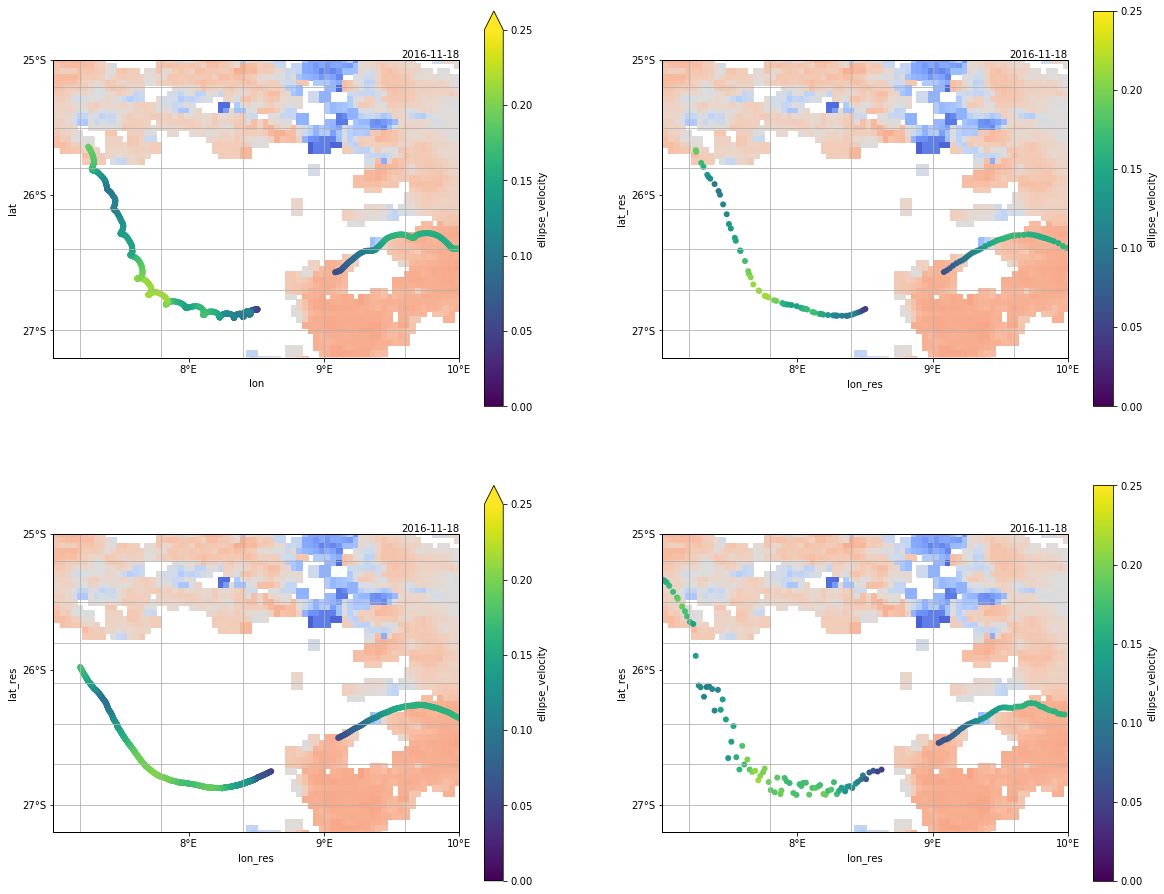

In [194]:
key = 'Drifter5'
dlon = 0.02
binned_lons = np.arange(x_y_lim[0],x_y_lim[1],dlon)
binned_lons_c = binned_lons[0:-1]+(dlon/2)
vel_range = np.array((0,0.25))

nrows, ncols =  2,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== velocities from one example drifter
# SST map, ship track and transects
si = 0
projection = ccrs.PlateCarree()
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors
((drifter_ds.set_coords(['lat','lon']).sel(time=sel_time,velocity_type=['vbar'],drifter=key).squeeze()).
 plot.scatter(x='lon',y='lat',hue='ellipse_velocity',ax=axs[si],vmin=vel_range[0],vmax=vel_range[1],
              edgecolors='k',linewidths=0.,marker='o',transform=projection,add_guide=False))

#  ==== binned velocities from one example drifter
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

((drifter_ds.set_coords(['lat','lon']).sel(time=sel_time,velocity_type=['vbar'],drifter=key).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()).
 plot.scatter(x='lon_res',y='lat_res',hue='ellipse_velocity',ax=axs[si],vmin=vel_range[0],vmax=vel_range[1],
              edgecolors='k', linewidths=0.,marker='o',transform=projection,add_guide=False))

# ==== velocities from drifter mean
# SST map, ship track and transects
si = 2
projection = ccrs.PlateCarree()
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

((drifter_ds.set_coords(['lat','lon']).sel(time=sel_time,velocity_type=['vbar']).mean('drifter').squeeze()).
 plot.scatter(x='lon_res',y='lat_res',hue='ellipse_velocity',ax=axs[si],vmin=vel_range[0],vmax=vel_range[1],
              edgecolors='k', linewidths=0.,marker='o',transform=projection,add_guide=False))

#  ==== binned velocities from drifter mean
si = 3
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

((drifter_ds.set_coords(['lat','lon']).sel(time=sel_time,velocity_type=['vbar']).squeeze().
 groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()).
 plot.scatter(x='lon_res',y='lat_res',hue='ellipse_velocity',ax=axs[si],vmin=vel_range[0],vmax=vel_range[1],
              edgecolors='k', linewidths=0.,marker='o',transform=projection,add_guide=False))




In [ ]:
# show plot of where they slow down; drifter start out separated, mix together, then leave separated in a different order
# add a plot like those above but with pair separation? or is the visualization enough to show when they stick together and when the separate?
# add plots with temperature

#####    6. Submesoscale instabilities and mixing
- TO DO:
    - interpret these results: Thomas et al 2016, Adams, Thompson, ...
    - how does T-S diagram fit into restratification story?
- The compensating lateral density gradients outside of filament suggest restratification through frontal slumping and surface-layer instabilities, followed by mixing (Timmermans et al 2013)
- can be confirmed with Turner angle (horizontal density compensation)
    - Timmermans et al 2013: "In the mid-latitude oceans, an indirect signature of submesos- cale restratification is compensating lateral density gradients ... down to small lateral scales (e.g. Ferrari and Rudnick, 2000). ... Compensated temperature and salinity gradients are more prevalent where mixing levels are higher."
- near fronts, balanced Ri > 1 but Gradient Ri < 1, suggesting ageostrophic component makes the front unstable, not geostrophic
    - based on Timmermans et al 2013 statement that "Balanced Ri > 1, suggests fronts are unstable to ageostrophic baroclinic instabilities and Ri increases when submeso eddies restratify the mixed layer; where Balanced Ri assumes geostrophic flow, replacing vertical shear with geostrophic shear "
    - Ri < 0.25 indicate velocity shear is able to overcome stratification = mixing
- increase with distance offshore in spread in T-S diagram indicating mixing or advection of water masses not captured by near-shore transects 
- Analysis of Ri and PV indicates what type of instabilities may be forming
    - gravitational instabilities in surface layer, symmetric instabilities along sloping isopycnals at the filament edges/fronts


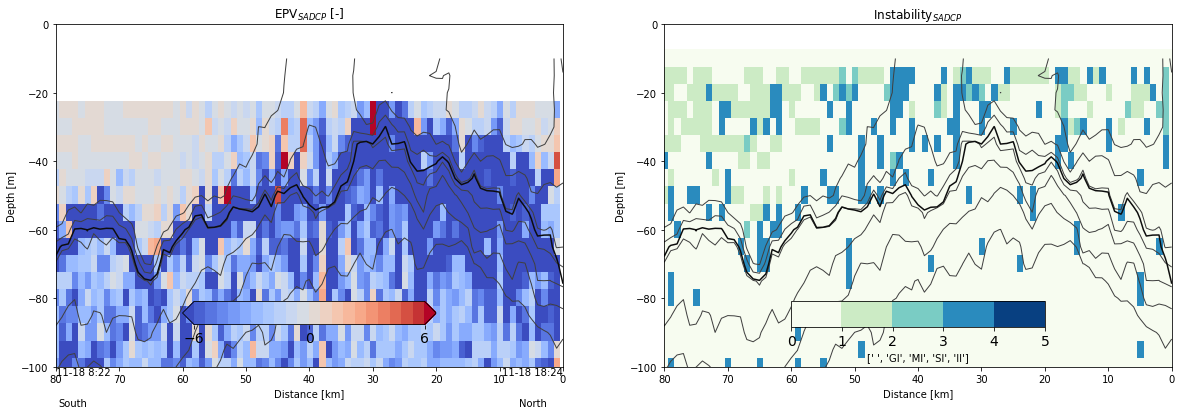

In [195]:
si, nrows, ncols =  0, 1,2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
x_lim, y_lim = [0,80], [-100,0]

var_names = list(('EPV_plot','Instability_StableGravMixSymInertStab'))
axs_out = fg.plot_profile_view(OrderedDict(islice(scan_sadcp_transects_1km_filament.items(), 0, 1)) , None, var_names, x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[0],axs[1])),last_row_flag=True, mld_flag = True,pcolormesh_flag=True)

figname = figure_dir+'Figure_6.png'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
# vel_all = [1]
# dlon = 0.05
# binned_lons = np.arange(x_y_lim[2],x_y_lim[1],dlon)
# binned_lons_c = binned_lons[0:-1]+(dlon/2)
# for key in drifters:
#     if type(vel_all) == list:
#         vel_all = (drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).velocity.
#                    groupby_bins('lon',binned_lons,labels=binned_lons_c).mean('time'))
#     else:
#         vel_all = xr.concat([vel_all, drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).velocity.
#                    groupby_bins('lon',binned_lons,labels=binned_lons_c).mean('time')],dim='x')
# vel_all.plot.line(x='lon_bins',lw=0,marker='o',add_legend=False,xlim=(x_y_lim[0],x_y_lim[1]))


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


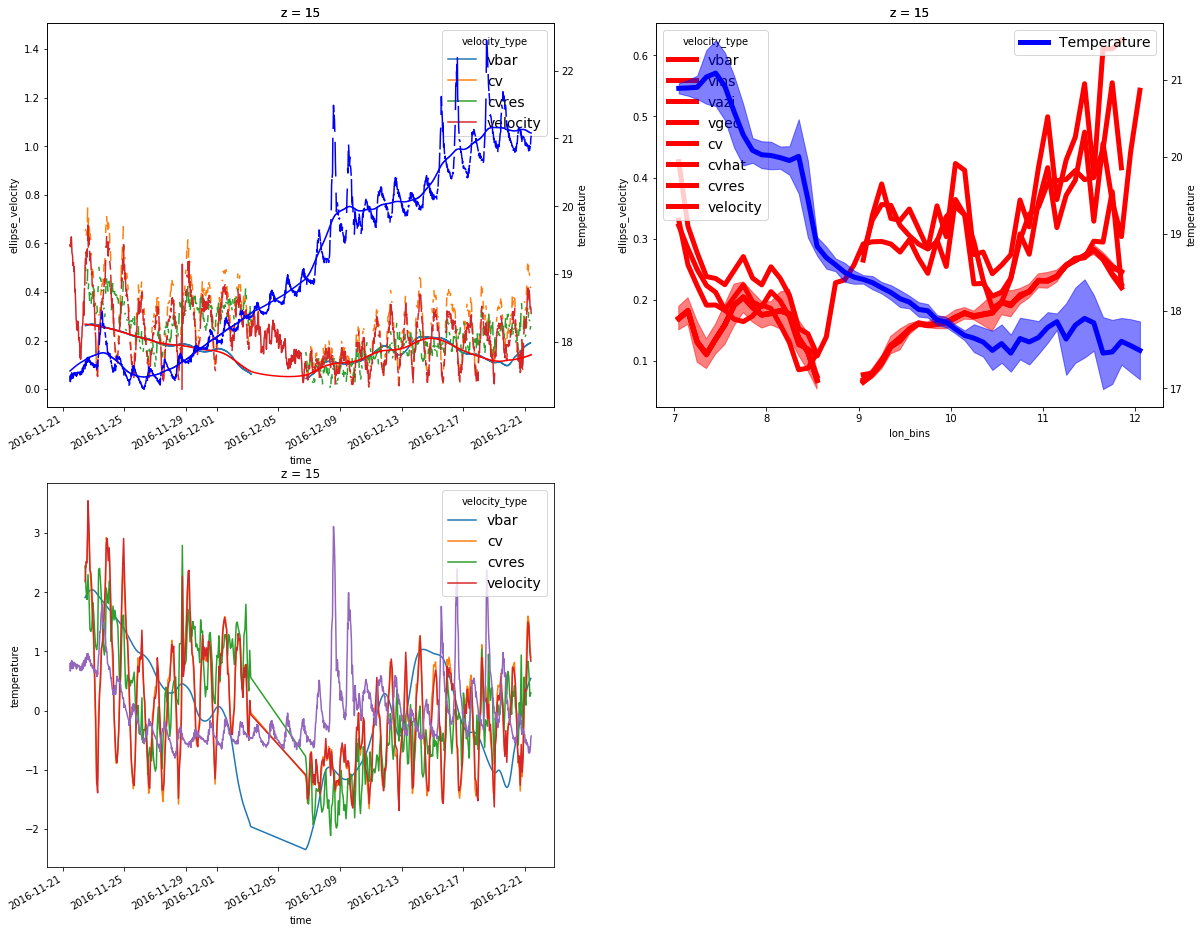

In [122]:
x_y_lim = [5.5,15.5,-24.,-29.25]
# combine drifters
vel_all = [1]
for key in drifters:
    if type(vel_all) == list:
        vel_all = (drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).ellipse_velocity.squeeze())
        temp_all = (drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).temperature.squeeze())
    else:
        vel_all = xr.concat([vel_all, drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).ellipse_velocity.squeeze()],dim='x')
        temp_all = xr.concat([temp_all, drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).temperature.squeeze()],dim='x')
        # plot all values as scatter points
        #(drifters[key].squeeze().reset_index('xy').set_coords(['lat','lon']).swap_dims({'xy':'time'}).sel(time=sel_time).velocity.squeeze().
        #     plot.line(x='lon',lw=0,marker='o',color='orange',alpha=0.1,add_legend=False,xlim=(x_y_lim[0],x_y_lim[1])))

std_dwn = (vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()-
          vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).std())
std_up = (vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()+
          vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).std())

ndays = 30
sel_time = slice(drifters['Drifter1'].time[0],drifters['Drifter1'].time[0].values  + np.timedelta64(ndays, 'D'))

key = 'Drifter5'

nrows, ncols =  3,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== time-series of various drifter velocities
si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)

drifter_velocities.ellipse_velocity.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).sel(velocity_type=['vbar','cv','cvres','velocity']).squeeze().plot(x='time',hue='velocity_type',ax=axs[si])


#drifters[key].ellipse_velocity.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).sel(velocity_type=['vbar','cv','cvres','velocity']).squeeze().plot(x='time',hue='velocity_type',ax=axs[si])
x = drifters[key].ellipse_velocity.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).sel(velocity_type=['vbar']).interpolate_na('time').dropna('time',how='all').squeeze()
y = ssa.ssafilter(x.values,130,[0])
axs[si].plot(x.time.values,y,color='red')

ax1 = axs[si].twinx()  # instantiate a second axes that shares the same x-axis

drifters[key].reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).temperature.plot(ax=ax1,color='blue')
T = ssa.ssafilter(drifters[key].reset_index('xy').swap_dims({'xy':'time'}).temperature.interpolate_na('time').sel(time=sel_time).squeeze().values,130,[0])
ax1.plot(drifters[key].reset_index('xy').swap_dims({'xy':'time'}).time.sel(time=sel_time).values,T,color='blue')

# ==== groupby longitude and take mean/std
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1)

# plot grouped data by longitude
axs[si].fill_between(binned_lons_c,std_dwn.sel(velocity_type=['vbar']).squeeze().values,std_up.sel(velocity_type=['vbar']).squeeze().values, alpha=0.5, color='red')
vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().plot.line(x='lon_bins', color='red',lw=5,#label='Velocity',
                                                                              ax=axs[si])

ax2 = axs[si].twinx()  # instantiate a second axes that shares the same x-axis
std_dwn_t = (temp_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()-
          temp_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).std())
std_up_t = (temp_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()+
          temp_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).std())
# plot grouped data by longitude
ax2.fill_between(binned_lons_c,std_dwn_t,std_up_t, alpha=0.5, color='blue')
temp_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().plot.line(x='lon_bins', color='blue',lw=5,label='Temperature',
                                                                               ax=ax2)

lines, labels = axs[si].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# ==== 
si = 2
axs[si] = plt.subplot(nrows, ncols, si+1)
d_standard = drifters[key].ellipse_velocity.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).sel(velocity_type=['vbar','cv','cvres','velocity']).dropna('time',how='all').squeeze() 
d_standard = (d_standard-d_standard.mean('time'))/d_standard.std('time')
d_standard.plot(x='time',hue='velocity_type',ax=axs[si])
d_standard = drifters[key].temperature.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).dropna('time',how='all').squeeze() 
d_standard = (d_standard-d_standard.mean('time'))/d_standard.std('time')
d_standard.values = sp.signal.detrend(d_standard.values, type='linear')
(d_standard*2).plot(x='time',ax=axs[si])



7 10
7 10


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7 10
7 10


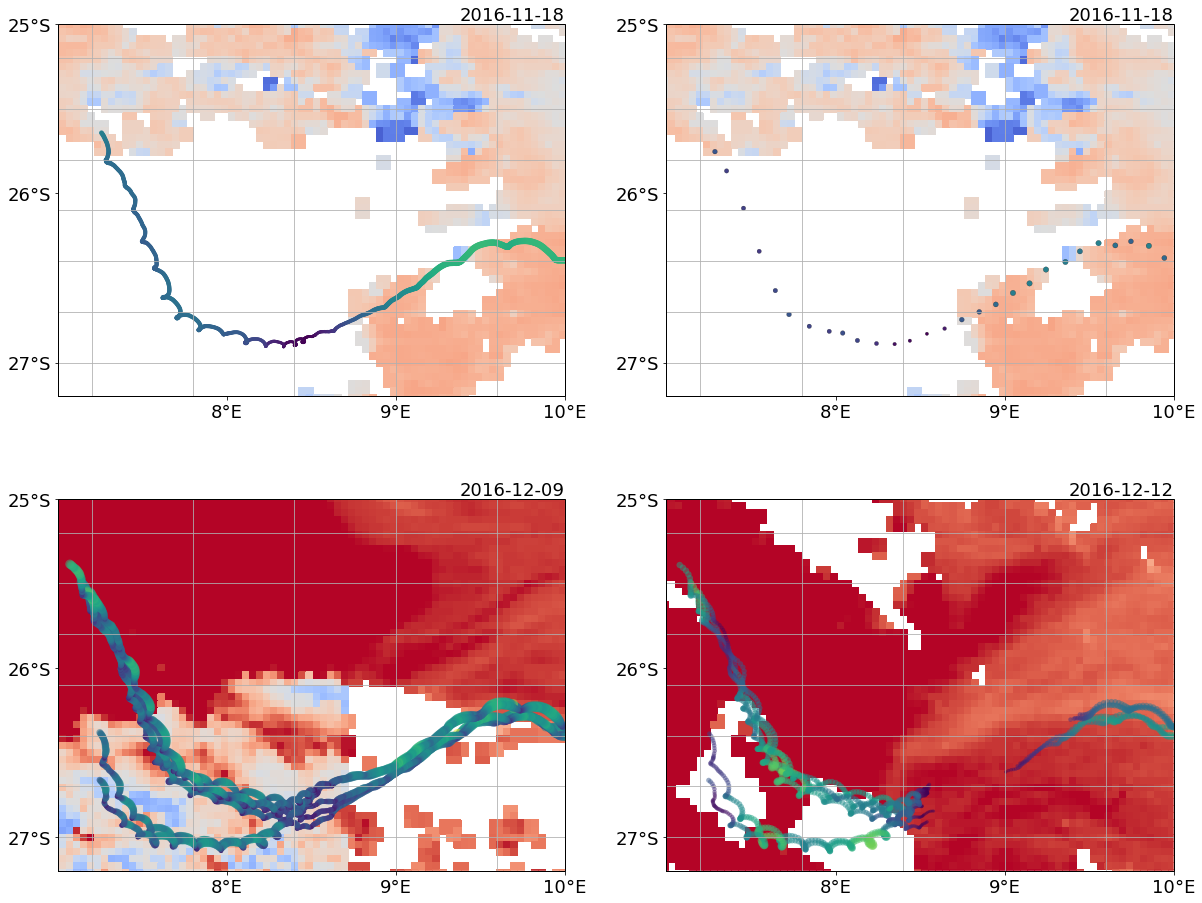

In [12]:
!!! redo maps using new variable setup



key = 'Drifter5'

nrows, ncols =  2,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 
axs = [None]*nrows*ncols

# ==== velocities from one example drifter
# SST map, ship track and transects
si = 0
projection = ccrs.PlateCarree()
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

y = ssa.ssafilter(drifters[key].reset_index('xy').swap_dims({'xy':'time'}).velocity.interpolate_na('time').sel(time=sel_time).squeeze().values,130,[0])
plt.scatter(drifters[key].lon.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).squeeze(),
            drifters[key].lat.reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).squeeze(),
            s=abs(10**(5*y)), c=y, cmap = plt.cm.viridis, transform=projection)

#  ==== binned velocities from one example drifter
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1118'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

y2 = vel_all.groupby_bins('lon',binned_lons,labels=binned_lons_c).mean()
axs[si].scatter(drifters[key].reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).squeeze().groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().lon.values,
         drifters[key].reset_index('xy').swap_dims({'xy':'time'}).sel(time=sel_time).squeeze().groupby_bins('lon',binned_lons,labels=binned_lons_c).mean().lat.values,
         s=y2*100, c=y2,cmap = plt.cm.viridis, edgecolors='k', linewidths=0.2,marker='o',transform=projection)

# ==== orig vel; example of slowing down and pair separation/mixing
si = 2
#  SST map and drifters
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
x_y_lim = [7,10,-25.,-27.2]
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1209'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

sik = 0
for key in list(drifters.keys())[1::2]:
    axs[si].scatter(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    s=200*drifters[key].velocity.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    c=drifters[key].velocity.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    marker='o',lw = 0, alpha=0.5, transform= projection)
    
# ==== vbar; example of slowing down and pair separation/mixing
si = 3
#  SST map and drifters
axs[si] = plt.subplot(nrows, ncols, si+1, projection=projection)
x_y_lim = [7,10,-25.,-27.2]
axs[si] = fg.plot_map_view(sadcp=sadcp, scan_sadcp = None, topo=None,
                           sst_map=sst_map['sst_map_1212'], sst_map1=None, x_lim=[0,150],
                           axs=[axs[si],x_y_lim[0],x_y_lim[1],x_y_lim[2],x_y_lim[3]],projection = projection)
axs[si].gridlines()
axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

sik = 0
for key in list(drifters.keys())[1::2]: # not plotting every drifter
    axs[si].scatter(drifters[key].lon.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    drifters[key].lat.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    s=200*drifters[key].vbar.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    c=drifters[key].vbar.isel(z=0).reset_index('xy').swap_dims({'xy': 'time'}).sel(time=sel_time).values,
                    marker='o',lw = 0, alpha=0.5, transform= projection)
